# 第8週：傲慢與偏見之詞彙關係

**Author**: 蔡睿澤  
**Date created**: 2023/04/04  
**Last modified**: 2023/04/08<br><br>
本週課程為「文辭和文件分析」，目的為透過TF-IDF, N-gram等方法找出文章以及字詞間的關聯。在這個Jupyter Notebook中將會以古騰堡的傲慢與偏見做為分析資料。


## 大綱

1. 套件說明
2. TF-IDF
    - 2.1 計算每篇文章的詞數
    - 2.2 計算tf-idf值
    - 2.3 檢視結果
3. 斷詞與N-gram
    - 3.1 Bigram
    - 3.2 Trigram
4. 建立Ngram預測模型
5. Bigram視覺化
6. Pairwise correlation
    - 6.1 找出相關性高的詞彙
7. 計算文章相似度

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- jieba: 中文斷詞套件。
- re: 正規表達式套件。
- math: 數學運算工具。
- collections: 提供額外的數據類型。
- wordcloud: 文字雲繪圖工具。
- matplotlib: 繪圖工具。
- networkx: 網絡圖建構、繪製工具。
- CountVectorizer,TfidfTransformer: sklearn中計算詞頻與tf-idf的套件。
- numpy.linalg: 矩陣與向量運算套件。

In [2]:
# pip install -U networkx

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import re
import nltk
#nltk.download("punkt")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from datetime import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm

#### 匯入資料
- 資料來源: 古騰堡-傲慢與偏見

In [4]:
#匯入資料
MetaData = pd.read_csv('./raw_data/en_tp_clean.csv')

In [5]:
MetaData

,sentence,chapter
0,TPRIDE PREJUDICE,0
1,It is a truth universally acknowledged that a ...,1
2,However little known the feelings or views of ...,1
3,My dear Mr_Bennet said his lady to him one day...,1
4,Mr_Bennet replied that he had not,1
...,...,...
5788,By Elizabeths instructions she began to compre...,61
5789,Lady Catherine was extremely indignant on the ...,61
5790,But at length by Elizabeths persuasion he was ...,61
5791,With the Gardiners they were always on the mos...,61


In [6]:
##新增stop words
nltk.download('stopwords')
stopWords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brandon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# 設定斷詞 function
stemmer = PorterStemmer() #做Stemming還原詞幹

def getToken(row):
    seg_list = nltk.tokenize.word_tokenize(row)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    return seg_list

In [8]:
data = MetaData.copy()
data['word'] = data['sentence'].apply(getToken)
data = data.explode('word')
data.reset_index(inplace=True, drop=True) #重設index
data.head()

,sentence,chapter,word
0,TPRIDE PREJUDICE,0,tpride
1,TPRIDE PREJUDICE,0,prejudic
2,It is a truth universally acknowledged that a ...,1,truth
3,It is a truth universally acknowledged that a ...,1,univers
4,It is a truth universally acknowledged that a ...,1,acknowledg


## 2. TF-IDF
TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度。
- **TF** (Term Frequency)：某一個詞彙在某一個文件中所出現的頻率  
    - TF = 詞彙在該文件中出現次數 / 該文件中詞彙總數  
- **IDF** (Inverse Document Frequent)：為文件數除以某特定詞彙有被多少文件所提及的數量取log  
    - IDF = log( 總文件數量 / 包含該詞彙的文件數量 ) 

### 2.1 計算每個章節的 總詞彙數 與 各個詞彙數

In [9]:
# 各章節的總詞彙數
total_words = data.groupby(['chapter'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,chapter,total
0,0,2
1,1,357
2,2,325
3,3,775
4,4,468
...,...,...
57,57,723
58,58,1028
59,59,1070
60,60,680


In [10]:
# 計算各詞彙在各章節中出現的次數
word_count = data.groupby(["chapter","word"],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)
word_count

,chapter,word,count
0,0,prejudic,1
1,0,tpride,1
2,1,abus,1
3,1,account,1
4,1,acknowledg,1
...,...,...,...
30619,61,year,2
30620,61,yet,2
30621,61,young,1
30622,61,younger,1


#### 合併需要的資料欄位
- 合併 **每個詞彙在每個章節中出現的次數** 與 **每個章節的總詞數**

In [11]:
tp_words = word_count.merge(total_words,on = 'chapter',how = 'left')
tp_words.head(10)

,chapter,word,count,total
0,0,prejudic,1,2
1,0,tpride,1,2
2,1,abus,1,357
3,1,account,1,357
4,1,acknowledg,1,357
5,1,affect,1,357
6,1,agre,1,357
7,1,ah,1,357
8,1,alway,1,357
9,1,answer,1,357


### 2.2 計算 tf-idf 值
- 以每個章節爲單位，計算每個詞彙的 tf-idf 值  
    - tf-idf = tf * idf

In [12]:
# 計算tf
tp_words_tf_idf = tp_words.assign(tf = tp_words.iloc[:,2]/tp_words.iloc[:,3])
tp_words_tf_idf.head()

,chapter,word,count,total,tf
0,0,prejudic,1,2,0.500000
1,0,tpride,1,2,0.500000
2,1,abus,1,357,0.002801
3,1,account,1,357,0.002801
4,1,acknowledg,1,357,0.002801


In [13]:
# 計算每個詞彙出現在幾篇文章中
idf_df = tp_words.groupby(['word'],as_index=False).size()
tp_words_tf_idf = tp_words_tf_idf.merge(idf_df,on = 'word',how = 'left')
tp_words_tf_idf.head()

,chapter,word,count,total,tf,size
0,0,prejudic,1,2,0.500000,9
1,0,tpride,1,2,0.500000,1
2,1,abus,1,357,0.002801,8
3,1,account,1,357,0.002801,25
4,1,acknowledg,1,357,0.002801,26


In [14]:
# 計算idf
tp_words_tf_idf = tp_words_tf_idf.assign(idf = tp_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

tp_words_tf_idf = tp_words_tf_idf.drop(labels=['size'],axis=1)
tp_words_tf_idf.head()

,chapter,word,count,total,tf,idf
0,0,prejudic,1,2,0.500000,0.838149
1,0,tpride,1,2,0.500000,1.792392
2,1,abus,1,357,0.002801,0.889302
3,1,account,1,357,0.002801,0.394452
4,1,acknowledg,1,357,0.002801,0.377418


In [15]:
# 計算 tf-idf
tp_words_tf_idf = tp_words_tf_idf.assign(tf_idf = tp_words_tf_idf.iloc[:,4] * tp_words_tf_idf.iloc[:,5])
tp_words_tf_idf.head(10)

,chapter,word,count,total,tf,idf,tf_idf
0,0,prejudic,1,2,0.500000,0.838149,0.419075
1,0,tpride,1,2,0.500000,1.792392,0.896196
2,1,abus,1,357,0.002801,0.889302,0.002491
3,1,account,1,357,0.002801,0.394452,0.001105
4,1,acknowledg,1,357,0.002801,0.377418,0.001057
5,1,affect,1,357,0.002801,0.169142,0.000474
6,1,agre,1,357,0.002801,0.537119,0.001505
7,1,ah,1,357,0.002801,1.093422,0.003063
8,1,alway,1,357,0.002801,0.120294,0.000337
9,1,answer,1,357,0.002801,0.148939,0.000417


### 2.3 檢視結果

In [16]:
# 選出每個章節，tf-idf值最大的前五個詞
group = tp_words_tf_idf.groupby("chapter").apply(lambda x : x.nlargest(5, "tf_idf"))

In [17]:
group.loc[:,["word","tf_idf"]][0:10]

word    tf_idf
chapter                         
0       1       tpride  0.896196
        0     prejudic  0.419075
1       205     twenti  0.009391
        179      singl  0.008415
        133       nerv  0.007368
        125  mr_bennet  0.006343
        128   mrs_long  0.005682
2       261      cough  0.022060
        358   mrs_long  0.012483
        367    nonsens  0.007737

#### 計算整個文集中較常 tf-idf 值高的字

In [18]:
# 從每個章節挑選出tf-idf最大的前十個詞
(tp_words_tf_idf.groupby("chapter").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(10) #排序看前十名

,word,size
284,mr_collin,8
296,mrs_gardin,7
259,lydia,7
240,kitti,6
59,catherin,5
63,charlott,5
75,colonel,5
104,danc,5
172,fitzwilliam,5
257,luca,4


## 3. 斷詞與N-gram
N-gram 指文本中連續出現的n個語詞。 透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。  
N-gram範例：

In [19]:
token = nltk.tokenize.word_tokenize("What A Beautiful Day")
token

['What', 'A', 'Beautiful', 'Day']

In [20]:
bigram  = ngrams(token, 2)
list(bigram)

[('What', 'A'), ('A', 'Beautiful'), ('Beautiful', 'Day')]

In [21]:
trigram  = ngrams(token, 3)
list(trigram)

[('What', 'A', 'Beautiful'), ('A', 'Beautiful', 'Day')]

### Bigram

In [22]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = nltk.tokenize.word_tokenize(row)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [23]:
tp_bigram = MetaData.copy()
tp_bigram["word"] = tp_bigram.sentence.apply(bigram_getToken)
tp_bigram = tp_bigram.explode('word')
tp_bigram

,sentence,chapter,word
0,TPRIDE PREJUDICE,0,tpride prejudic
1,It is a truth universally acknowledged that a ...,1,truth univers
1,It is a truth universally acknowledged that a ...,1,univers acknowledg
1,It is a truth universally acknowledged that a ...,1,acknowledg singl
1,It is a truth universally acknowledged that a ...,1,singl man
...,...,...,...
5792,Darcy as well as Elizabeth really loved them a...,61,toward person
5792,Darcy as well as Elizabeth really loved them a...,61,person bring
5792,Darcy as well as Elizabeth really loved them a...,61,bring derbyshir
5792,Darcy as well as Elizabeth really loved them a...,61,derbyshir mean


#### 統計最常出現的bigram組合

In [24]:
# 計算每個組合出現的次數
tp_bigram_count = tp_bigram.groupby(["word"],as_index=False).size()
tp_bigram_count.sort_values(by=['size'], ascending=False).head(15)

,word,size
18522,ladi catherin,114
22477,miss bingley,86
22476,miss bennet,71
11038,everi thing,58
30716,said elizabeth,46
32659,sir william,44
40390,young ladi,41
7819,de bourgh,38
22480,miss darci,38
40393,young man,37


### Trigram

In [25]:
# 設定 trigram 斷詞 function
def trigram_getToken(row):
    seg_list = nltk.tokenize.word_tokenize(row)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    seg_list = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [26]:
tp_trigram = MetaData.copy()
tp_trigram["word"] = tp_trigram.sentence.apply(trigram_getToken)
tp_trigram = tp_trigram.explode('word')
tp_trigram

,sentence,chapter,word
0,TPRIDE PREJUDICE,0,NaN
1,It is a truth universally acknowledged that a ...,1,truth univers acknowledg
1,It is a truth universally acknowledged that a ...,1,univers acknowledg singl
1,It is a truth universally acknowledged that a ...,1,acknowledg singl man
1,It is a truth universally acknowledged that a ...,1,singl man possess
...,...,...,...
5792,Darcy as well as Elizabeth really loved them a...,61,gratitud toward person
5792,Darcy as well as Elizabeth really loved them a...,61,toward person bring
5792,Darcy as well as Elizabeth really loved them a...,61,person bring derbyshir
5792,Darcy as well as Elizabeth really loved them a...,61,bring derbyshir mean


#### 統計最常出現的trigram組合

In [27]:
# 計算每個組合出現的次數
tp_trigram_count = tp_trigram.groupby(["word"],as_index=False).size()
tp_trigram_count.sort_values(by=['size'], ascending=False).head(15)

,word,size
23490,miss de bourgh,19
19134,ladi catherin de,14
4557,catherin de bourgh,14
24854,mrs_hurst miss bingley,9
32034,said miss bingley,8
19133,ladi catherin daughter,8
34034,sir william luca,7
36672,ten thousand pound,6
23500,miss elizabeth bennet,5
23343,miss bennet came,4


從上面的 bigram 和 trigram 的結果中，我們發現有些字較常一起出現。  

## 4. 建立Ngram預測模型
引入Markov假設，也就是當前的這個字僅僅與前幾個有限的字相關   
$$P(w_i|w_1,...,w_{i-1})=P(w_i|w_{i-m+1},...,w_{i-1})$$  
bi-gram (m=2):
$$ P(w_i|w_{i-1})=\frac {count(w_{i-1},w_i)} {count(w_{i-1})} $$   
tri-gram (m=3):  
$$ P(w_i|w_{i-2},w_{i-1})=\frac {count(w_{i-2},w_{i-1},w_i)} {count(w_{i-2},w_{i-1})} $$   



參考網站：
- [N-gram Language Models](https://towardsdatascience.com/n-gram-language-models-af6085435eeb)
- [自然語言處理 — 使用 N-gram 實現輸入文字預測](https://medium.com/%E6%89%8B%E5%AF%AB%E7%AD%86%E8%A8%98/%E8%87%AA%E7%84%B6%E8%AA%9E%E8%A8%80%E8%99%95%E7%90%86-%E4%BD%BF%E7%94%A8-n-gram-%E5%AF%A6%E7%8F%BE%E8%BC%B8%E5%85%A5%E6%96%87%E5%AD%97%E9%A0%90%E6%B8%AC-10ac622aab7a)
- [自然語言處理中N-Gram模型介紹](https://zhuanlan.zhihu.com/p/32829048)

In [28]:
data2 = MetaData.copy()
sen_tokens = data2['sentence'].apply(getToken).tolist()
sen_tokens[:2]

[['tpride', 'prejudic'],
 ['truth',
  'univers',
  'acknowledg',
  'singl',
  'man',
  'possess',
  'good',
  'fortun',
  'must',
  'want',
  'wife']]

In [29]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # 加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [30]:
# Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

**預測下一個出現的詞**

In [31]:
text = 'mr_darci'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: </s>, probability: 0.0847
next word: would, probability: 0.0323
next word: look, probability: 0.0242
next word: could, probability: 0.0161
next word: might, probability: 0.0161


In [32]:
text = 'marri'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: </s>, probability: 0.182
next word: daughter, probability: 0.0331
next word: mr_collin, probability: 0.0331
next word: girl, probability: 0.0248
next word: would, probability: 0.0248


## 5. bigram視覺化

In [33]:
#根據剛剛的觀察可以增加stopwords
stopWords.append('th')

In [34]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = nltk.tokenize.word_tokenize(row)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [35]:
fud_bigram2 = MetaData.copy()
fud_bigram2["word"] = fud_bigram2.sentence.apply(bigram_getToken_dict)
fud_bigram2 = fud_bigram2.explode('word')
fud_bigram2.head(3)

,sentence,chapter,word
0,TPRIDE PREJUDICE,0,tpride prejudic
1,It is a truth universally acknowledged that a ...,1,truth univers
1,It is a truth universally acknowledged that a ...,1,univers acknowledg


In [36]:
# 看一下bigramfdist內容
bigramfdist.most_common(5)

[(('ladi', 'catherin'), 114),
 (('miss', 'bingley'), 86),
 (('miss', 'bennet'), 71),
 (('everi', 'thing'), 58),
 (('said', 'elizabeth'), 46)]

In [37]:
# 建立bigram和count的dictionary
# 這裡取最多的前30項
d = {k:v for k,v in bigramfdist.most_common(30)}
d

{('ladi', 'catherin'): 114,
 ('miss', 'bingley'): 86,
 ('miss', 'bennet'): 71,
 ('everi', 'thing'): 58,
 ('said', 'elizabeth'): 46,
 ('sir', 'william'): 44,
 ('young', 'ladi'): 41,
 ('miss', 'darci'): 38,
 ('de', 'bourgh'): 38,
 ('young', 'man'): 37,
 ('everi', 'bodi'): 33,
 ('dare', 'say'): 31,
 ('colonel', 'fitzwilliam'): 30,
 ('colonel', 'forster'): 27,
 ('elizabeth', 'could'): 25,
 ('great', 'deal'): 24,
 ('miss', 'luca'): 23,
 ('cri', 'elizabeth'): 23,
 ('uncl', 'aunt'): 23,
 ('went', 'away'): 21,
 ('could', 'help'): 20,
 ('thousand', 'pound'): 20,
 ('half', 'hour'): 20,
 ('miss', 'de'): 20,
 ('next', 'morn'): 19,
 ('ladi', 'luca'): 18,
 ('repli', 'elizabeth'): 18,
 ('made', 'answer'): 17,
 ('good', 'humour'): 17,
 ('much', 'better'): 17}

In [38]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.05 for w in  G.edges(data=True)]

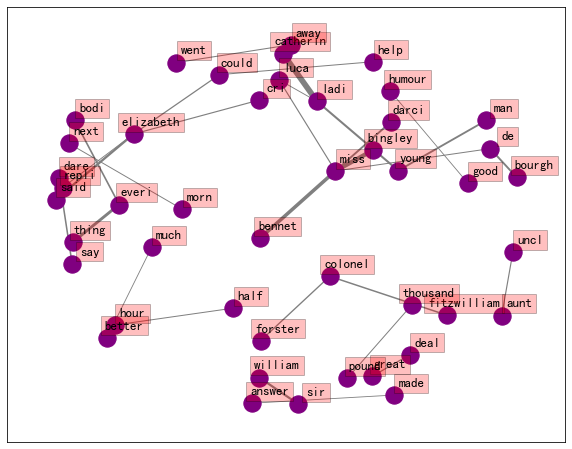

In [39]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## 6. Pairwise correlation
計算兩個詞彙間的相關性 Phi相關係數(Phi coefficient)  
<img src="./img/pic1.png" style="float:left;" width="50%">  
<img src="./img/pic2.png" style="float:left;" width="25%">

In [40]:
#取常一起出現的bigram pair 前2000筆
b = {k:v for k,v in bigramfdist.most_common(2000)}
# b.items()

In [ ]:
#建立DataFrame
bigram_df = pd.DataFrame(columns=['word', 'word2','n'])
for k,v in b.items():
    bigram_df = bigram_df.append({'word':k[0], 'word2':k[1], 'n':v}, ignore_index=True)

In [42]:
bigram_df.head()

,word,word2,n
0,ladi,catherin,114
1,miss,bingley,86
2,miss,bennet,71
3,everi,thing,58
4,said,elizabeth,46


In [43]:
# 計算phi值
def phi_cor(df):
    #total x
    nx = len(set(word_count[word_count["word"]==df["word"]]["chapter"]))
    tnx = len(MetaData)-nx
    #total y
    ny = len(set(word_count[word_count["word"]==df["word2"]]["chapter"]))
    tny = len(MetaData)-ny
    #有x 有y
    x_ls = list(word_count[word_count["word"]==df["word"]]["chapter"]) #單獨有x
    y_ls = list(word_count[word_count["word"]==df["word2"]]["chapter"]) #單獨有y
    nxy = len(set(x_ls)&set(y_ls)) #取交集
    #有x 沒有y
    nxo = nx-nxy
    #沒有x 沒有y
    uxy = set(x_ls)|set(y_ls) #取聯集
    noo = len(set(list(MetaData["chapter"]))-uxy) #取差集:全-有x有y
    #沒有x 有y
    noy = ny-nxy
    #print(nx,ny,tny,tnx,nxy,noo,nxo,noy)
    phi = (nxy*noo-nxo*noy)/math.sqrt(nx*ny*tny*tnx)
    
    return phi

In [44]:
bigram_df["cor"] = bigram_df.apply(phi_cor, axis=1)
bigram_df = bigram_df[bigram_df["word"]!=bigram_df["word2"]]

In [45]:
bigram_df

,word,word2,n,cor
0,ladi,catherin,114,0.000907
1,miss,bingley,86,0.000270
2,miss,bennet,71,0.000775
3,everi,thing,58,0.000287
4,said,elizabeth,46,0.000164
...,...,...,...,...
1995,alway,pleas,2,0.000304
1996,howev,made,2,0.000416
1997,widow,sir,2,0.000901
1998,earnest,endeavour,2,0.001051


### 6.1 和 mr_darci, marri 相關性最高的 8 個詞彙

In [46]:
d_sum = bigram_df[(bigram_df["word"]=="mr_darci")].sort_values(by=['cor'], ascending = False).head(8)
m_sum = bigram_df[(bigram_df["word"]=="marri")].sort_values(by=['cor'], ascending = False).head(8)

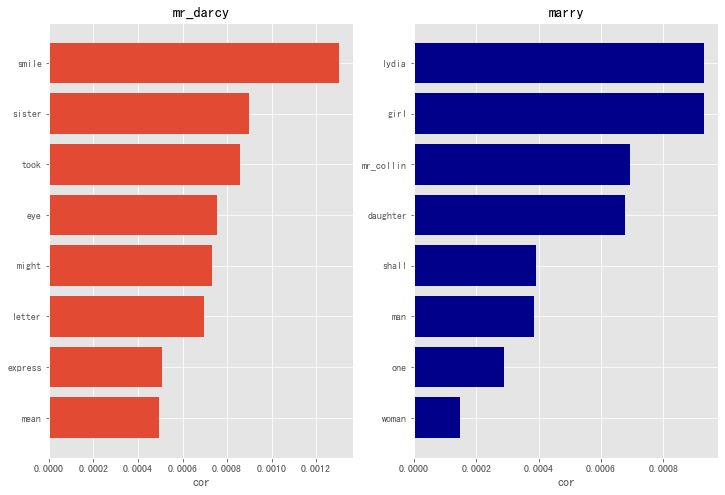

In [47]:
d_sum = d_sum.sort_values(by=['cor'])
m_sum = m_sum.sort_values(by=['cor'])

plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
# plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('mr_darcy')
plt.xlabel('cor')
plt.barh(d_sum['word2'],d_sum['cor'])

plt.subplot(122)
plt.title('marry')
plt.xlabel('cor')
plt.barh(m_sum['word2'],m_sum['cor'],color="darkblue")


plt.show()

## 7. 計算章節相似度
以TF-IDF的結果當作章節的向量，計算 Cosine Similarity 找出相似的章節   
<img src="./img/pic3.PNG" style="float:left;" width="50%">  

In [67]:
data_cos= MetaData.copy()
# 因為要算「章節」相似度，所以將每個章節的句子合併起來
data_cos = data_cos.groupby('chapter')['sentence'].apply(lambda x:x.str.cat(sep=' ')).reset_index()
# 需要改成使用空格連接斷好的詞
data_cos['word'] = data_cos.sentence.apply(getToken).map(' '.join)

In [68]:
data_cos.head()

,chapter,sentence,word
0,0,TPRIDE PREJUDICE,tpride prejudic
1,1,It is a truth universally acknowledged that a ...,truth univers acknowledg singl man possess goo...
2,2,Mr_Bennet was among the earliest of those who ...,mr_bennet among earliest wait mr_bingley alway...
3,3,Not all that Mrs_Bennet however with the assis...,mrs_bennet howev assist five daughter could as...
4,4,When Jane and Elizabeth were alone the former ...,jane elizabeth alon former cautiou prais mr_bi...


In [69]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_cos["word"])
vocabulary = vectorizer.get_feature_names_out()
# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df.head()

,abat,abhorr,abid,abil,abl,ablut,abod,abomin,abominablei,abound,...,youif,youll,youmr_bingley,young,younger,youngest,yoursdo,yourselfand,youth,youwil
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,2,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0


In [70]:
transformer = TfidfTransformer()  
print(transformer) 
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  
print(tfidf.toarray())

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df.head()

TfidfTransformer()
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.02952166 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.04740418 0.        ]]


,abat,abhorr,abid,abil,abl,ablut,abod,abomin,abominablei,abound,...,youif,youll,youmr_bingley,young,younger,youngest,yoursdo,yourselfand,youth,youwil
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.049809,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.024541,0.0,0.118221,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.055431,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.043700,0.0,0.000000,0.0,0.0,0.0,0.0


In [71]:
# 計算 cosine_similarity
def cosine_similarity(vector):
    cos_list = []
    for i in tfidf.toarray():
        score = np.dot(vector, i)  / (norm(vector) * norm(i))
        cos_list.append(score)
    df = pd.DataFrame(cos_list, columns=["cos_similarity"])
    return df

找和第1個章節相似的其他章節

In [72]:
print(tfidf.toarray()[1])
cos_df = cosine_similarity(tfidf.toarray()[1])

[0. 0. 0. ... 0. 0. 0.]


In [73]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
# cos_df.head()
cos_df.loc[:,["cos_similarity","chapter","sentence"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,chapter,sentence
1,1.000000,1,It is a truth universally acknowledged that a ...
53,0.323590,53,Mr_Wickham was so perfectly satisfied with thi...
2,0.313017,2,Mr_Bennet was among the earliest of those who ...
59,0.302659,59,My dear Lizzy where can you have been walking ...
7,0.288281,7,Mr_Bennets property consisted almost entirely ...
49,0.281878,49,Two days after Mr_Bennets return as Jane and E...
13,0.278563,13,I hope my dear said Mr_Bennet to his wife as t...
47,0.274253,47,It appears to me so very unlikely that any you...
52,0.268391,52,She was no sooner in possession of it than hur...
24,0.267945,24,Miss Bingleys letter arrived and put an end to...
